In [48]:
import sys
sys.path.append('../..')

import json
import pandas as pd

import torch
from torch.optim import SGD, Adam
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T
from torch.utils.tensorboard import SummaryWriter
from tools.gaia_dataset import SampleGaiaDataset
from tools.gnn_models import GCNEdgeBased
from tools.evaluation_metric import *
from tools.cluster_functions import *

In [49]:
writer = SummaryWriter()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

feature_columns = ['Etot', 'JR', 'Jz', 'Jphi']
position_columns = ['XGC', 'YGC', 'ZGC']

In [50]:
data_transforms = T.Compose(transforms=[T.KNNGraph(k=300, force_undirected=True), T.GDC(sparsification_kwargs={'avg_degree':300, 'method':'threshold'})]) #
gaia_dataset = SampleGaiaDataset('../../data/gaia', feature_columns, sample_size=16000, num_samples=2, pre_transform=data_transforms)
gaia_loader = DataLoader(gaia_dataset, batch_size=1, shuffle=True)

Processing...
Done!


In [51]:
model = GANOrigEdgeBased(len(feature_columns), regularizer=0).to(device)
model.load_state_dict(torch.load('../../train_script/weights/GANOrigEdgeBased_model300new_gaia_mom/299.pth')['model_state_dict'])

<All keys matched successfully>

In [61]:
from scipy.sparse import csr_matrix
def evaluate(n_components, graph, model):
    graph = graph.to(device)
    with torch.no_grad():
        model.eval()
        edge_pred = model(graph)
    adj = csr_matrix((edge_pred.cpu(),graph.edge_index.cpu()), shape=(len(graph.x), len(graph.x)))    
    FX = C_Spectral(adj, n_components=n_components)
    return FX

In [62]:
graph = next(iter(gaia_loader))
FX = evaluate(5, graph, model)
clusters = [f'cluster {idx}' for idx in FX]

/home/michaelyhuang/venv/gaia/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/michaelyhuang/venv/gaia/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette(sns.color_palette("colorblind"))

In [64]:
local_graph = graph.to('cpu')
X = gaia_dataset.de_normalize(local_graph.x)

In [65]:
from collections import Counter
counts = Counter(clusters).most_common()
top2 = [key for (key, c) in counts[:]]
print(top2)

['cluster 4', 'cluster 1', 'cluster 0', 'cluster 2', 'cluster 3']


In [66]:
X = X[np.isin(clusters, top2)]
clusters = [cluster for cluster in clusters if cluster in top2]

In [67]:
df_x = pd.DataFrame(X, columns = feature_columns)

<AxesSubplot: >

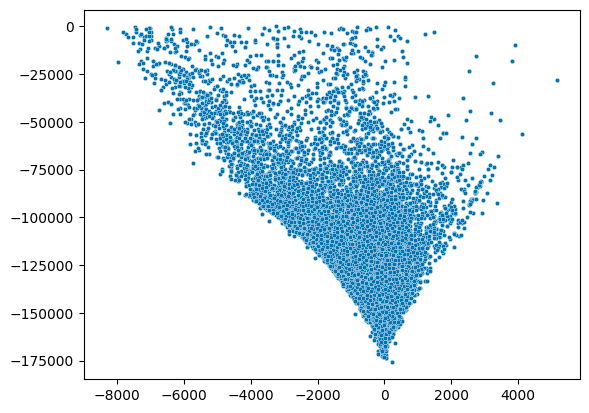

In [68]:
sns.scatterplot(x=X[:,3], y=X[:,0], s=10)

ValueError: Could not interpret value `vr` for parameter `x`

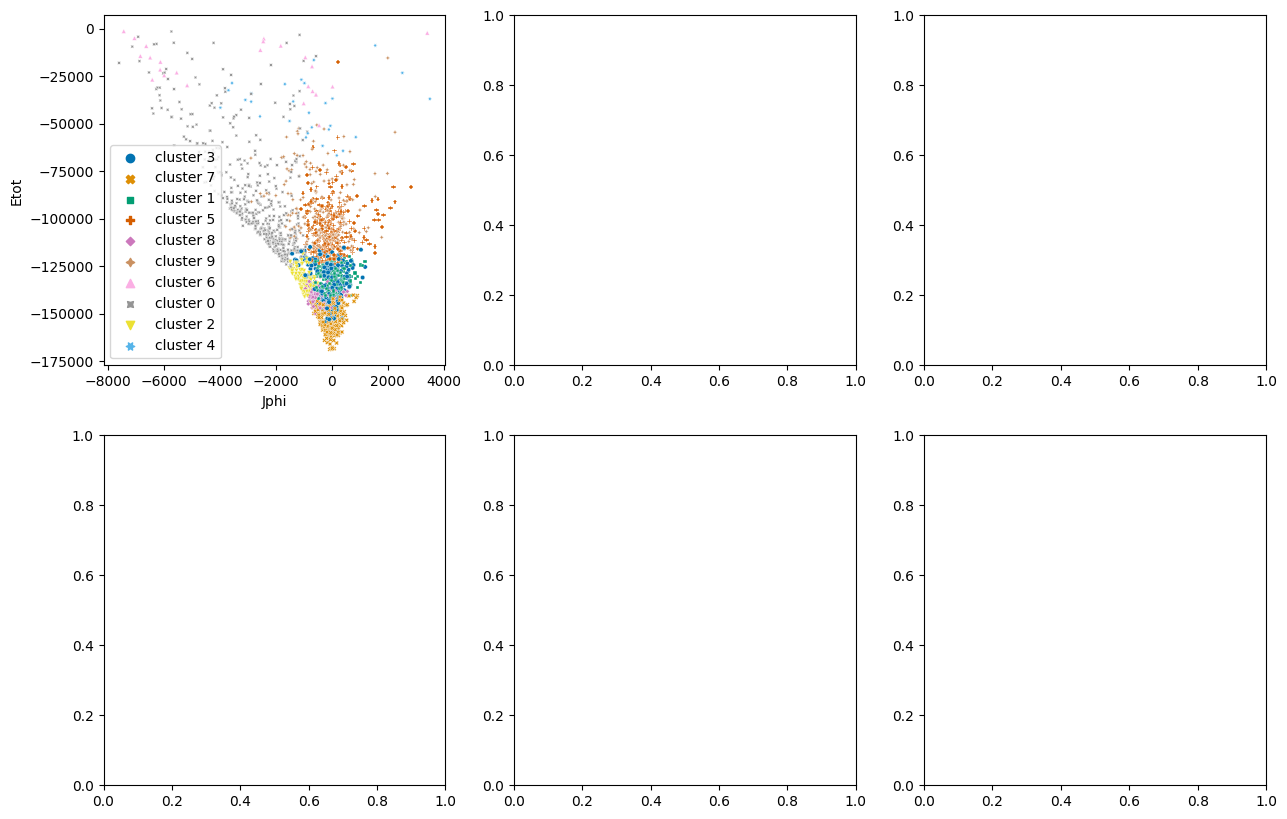

In [19]:
fig, axs = plt.subplots(ncols=3,nrows=2,figsize=(15, 10))
axs = axs.flatten()
sns.scatterplot(data=df_x, x='Jphi', y='Etot', hue=clusters, style=clusters, s=10, ax=axs[0])
sns.scatterplot(data=df_x, x='vr', y='vphi', hue=clusters, style=clusters, s=10, ax=axs[1])
sns.scatterplot(data=df_x, x='vr', y='W', hue=clusters, style=clusters, s=10, ax=axs[2])
J = np.sqrt(X[:,3]**2 + X[:,2]**2 + X[:,1]**2)
sns.scatterplot(x=X[:,3]/J, y=(X[:,2]-X[:,1])/J, hue=clusters, style=clusters, s=10, ax=axs[3])
sns.scatterplot(data=df_x, x='JR', y='Jphi', hue=clusters, style=clusters, s=10, ax=axs[4])
sns.scatterplot(data=df_x, x='JR', y='Jz', hue=clusters, style=clusters, s=10, ax=axs[5])

<AxesSubplot: xlabel='JR', ylabel='Jz'>

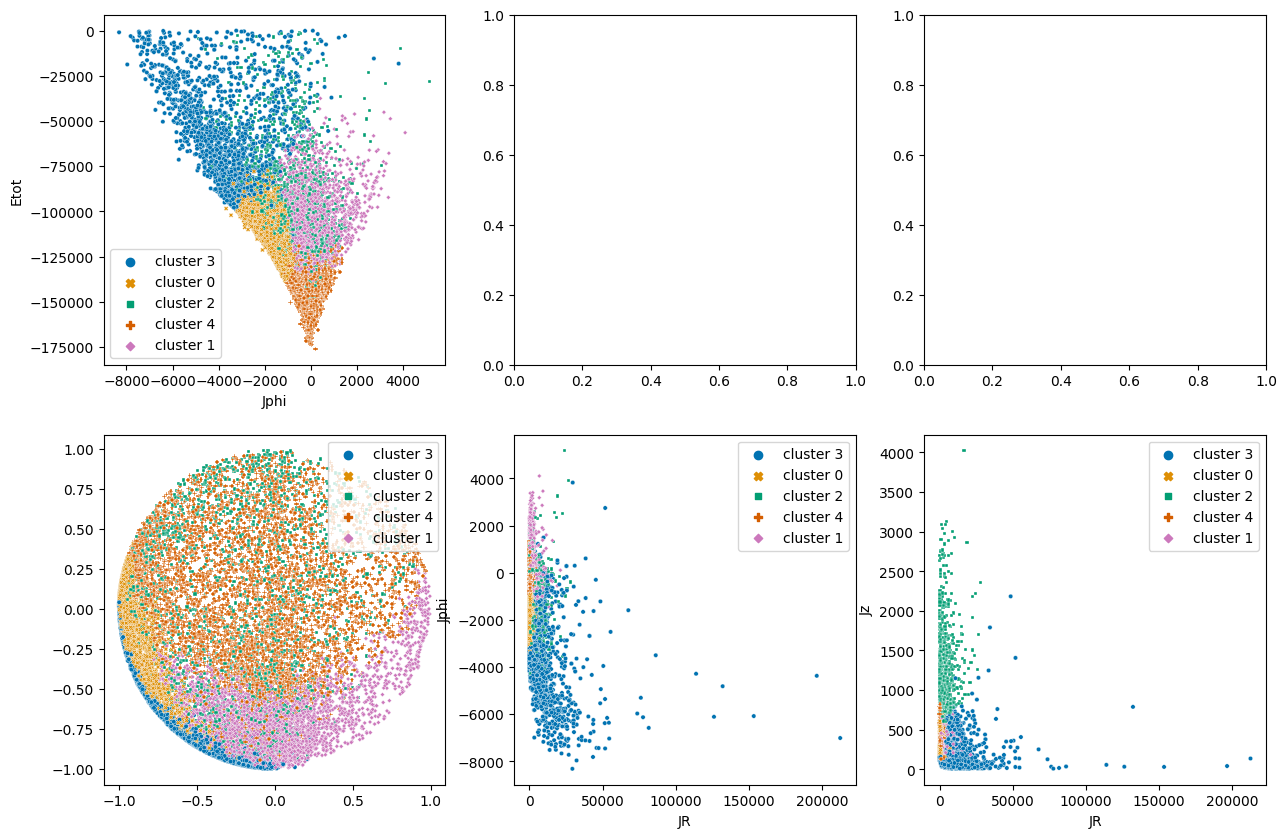

In [69]:
fig, axs = plt.subplots(ncols=3,nrows=2,figsize=(15, 10))
axs = axs.flatten()
sns.scatterplot(data=df_x, x='Jphi', y='Etot', hue=clusters, style=clusters, s=10, ax=axs[0])
J = np.sqrt(X[:,3]**2 + X[:,2]**2 + X[:,1]**2)
sns.scatterplot(x=X[:,3]/J, y=(X[:,2]-X[:,1])/J, hue=clusters, style=clusters, s=10, ax=axs[3])
sns.scatterplot(data=df_x, x='JR', y='Jphi', hue=clusters, style=clusters, s=10, ax=axs[4])
sns.scatterplot(data=df_x, x='JR', y='Jz', hue=clusters, style=clusters, s=10, ax=axs[5])

In [ ]:
sns.scatterplot(x=X[:,9], y=X[:,10], hue=clusters, style=clusters, s=10)

In [ ]:
J = np.sqrt(X[:,3]**2 + X[:,2]**2 + X[:,1]**2)
ax = sns.scatterplot(x=X[:,3]/J, y=(X[:,2]-X[:,1])/J, hue=clusters, style=clusters, s=10)

In [ ]:
ax = sns.scatterplot(x=X[:,1], y=X[:,2], hue=clusters, style=clusters, s=10)
ax.set(xlim=[0,20000])

In [ ]:
ax = sns.scatterplot(x=X[:,4], y=X[:,12], hue=clusters, style=clusters, s=10)

In [ ]:
POS = [X[:,4]*torch.cos(X[:,11]),X[:,4]*torch.sin(X[:,11]),X[:,12]]
ax = sns.scatterplot(x=POS[0], y=POS[1], hue=clusters, style=clusters, s=10)

In [ ]:
ax = sns.scatterplot(x=X[:,11], y=X[:,4], hue=clusters, style=clusters, s=10)